In [ ]:
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn import linear_model
from sklearn.metrics import r2_score

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

In [ ]:
confirm_checksum('/content/drive/MyDrive/CV Notebooks/CV Report/training_images.npz', 
                 'f313a54fc57a1235e6307d176fc5fc83fd7ec530')
data = np.load('/content/drive/MyDrive/CV Notebooks/CV Report/training_images.npz', 
               allow_pickle=True)
# training validation splits 10:90 = 281, 20:80 = 562, 30:70 = 843, 40:60 = 1124, 
# 50:50 = 1406, 60:40 = 1687, 70:30 = 1968, 80:20 = 2250 (chosen), 90:10 = 2530
images = data['images'][:2250]
pts = data['points'][:2250]
valid_images = data['images'][2250:]
valid_pts = data['points'][2250:]
print('Training Images Shape:  ', images.shape)
print('Training Points Shape:  ', pts.shape)
print('Validation Images Shape:', valid_images.shape)
print('Validation Points Shape:', valid_pts.shape)


confirm_checksum('/content/drive/MyDrive/CV Notebooks/CV Report/test_images.npz', 
                 '4b9efd8eb3b87c07d9c5400ef2494d476bc318a3')
test_data = np.load('/content/drive/MyDrive/CV Notebooks/CV Report/test_images.npz', 
                    allow_pickle=True)
test_images = test_data['images']
print('Test Images Shape:      ', test_images.shape)


confirm_checksum('/content/drive/MyDrive/CV Notebooks/CV Report/examples.npz', 
                 'bf51ebbf42f17e3cbe06bb299746565c53d16c40')
example_data = np.load('/content/drive/MyDrive/CV Notebooks/CV Report/examples.npz', 
                    allow_pickle=True)
example_images = example_data['images']
print('Example Images Shape:   ', example_images.shape)

Training Images Shape:   (2250, 244, 244, 3)
Training Points Shape:   (2250, 42, 2)
Validation Images Shape: (561, 244, 244, 3)
Validation Points Shape: (561, 42, 2)
Test Images Shape:       (554, 244, 244, 3)
Example Images Shape:    (6, 244, 244, 3)


# Face Alignment

In [ ]:
def visualise_pts(img, pts):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*42, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

In [ ]:
class Linear_Model:
    def __init__(self, images, pts):  
        # store the optimal point locations     
        self.pts = self.get_optimal_pts(pts) 
        self.models = []
        # initialize a linear regression model, compute the feature descriptors for a specific point, 
        # and fit each linear regressor with the corresponding descriptors and ground truth point locations
        for i in tqdm(range(len(pts[0]))):
            self.models.append(linear_model.LinearRegression())
            self.models[i].fit(self.compute_pt_img_des(images, i), pts[:, i])

    def predict(self, images):
        """
        Returns the predicted points for all given images.
        :param images: The images that are going to have their face alignment points predicted.
        :return: The predicted points for all given images.
        """
        pred_pts = []
        for i in tqdm(range(len(self.pts))):
            pred_pts.append(self.models[i].predict(self.compute_pt_img_des(images, i)))
        # reshaping to make the predictions have a shape of (num_of_samples, num_of_points, 2) 
        # while still perserving the right point-to-image relationship
        return np.array([[pred_pts[i][j] for i in range(len(pred_pts))] for j in range(len(pred_pts[0]))])

    def compute_pt_img_des(self, images, pt_idx):
        """
        Returns the feature descriptors for a specific point
        :param images: The images from which the feature descriptors will be extracted
        :return: The feature descriptors for a the given point index (0 - 42)
        """
        sift = cv2.xfeatures2d.SIFT_create()
        pt_img_des = []
        for i, img in enumerate(images):
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            _, des = sift.compute(gray_img, [cv2.KeyPoint(self.pts[pt_idx][0], 
                                                       self.pts[pt_idx][1], 5)])
            des = np.concatenate(des, axis=0)
            pt_img_des.append(des)
        return pt_img_des

    
    def get_optimal_pts(self, pts):
        """
        Returns the mean location of each point in the given pts list, used for SIFT's keypoint locations
        :param optimal_pts: The points list containing the locations of all points in all images
        :return: The 42 optimal point locations
        """
        optimal_pts = []
        for i in range(len(pts[0])):
            optimal_pts.append([np.mean([img_pts[i][0] for img_pts in pts]), 
                                np.mean([img_pts[i][1] for img_pts in pts])])
        return optimal_pts

In [ ]:
model = Linear_Model(images, pts)
pred_pts = model.predict(valid_images)
dists = euclid_dist(pred_pts, valid_pts)

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
print(np.mean(dists))
print(np.std(dists))
print(np.median(dists))
print(np.min(dists))
print(np.max(dists))
# r2 score
print(r2_score(valid_pts.reshape(-1, 84), pred_pts.reshape(-1, 84)))

8.247393381819663
6.994468446244488
6.278604221938948
0.03777958145061825
75.57488662765013
0.46804078675630445


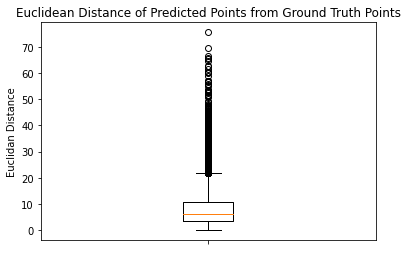

In [ ]:
plt.boxplot(dists, labels=' ')
plt.title('Euclidean Distance of Predicted Points from Ground Truth Points')
plt.ylabel('Euclidan Distance')
plt.show()

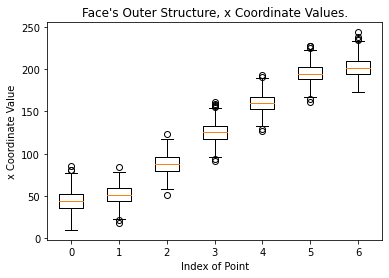

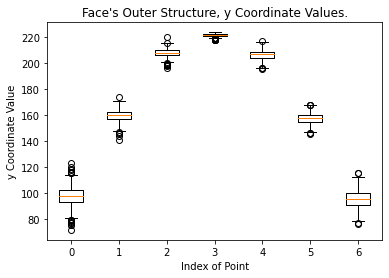

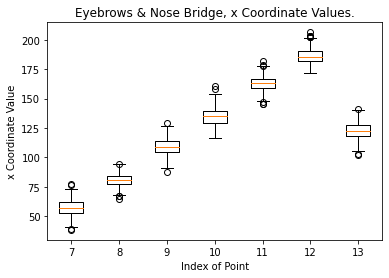

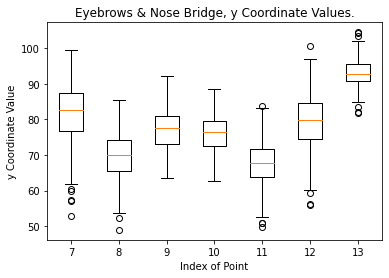

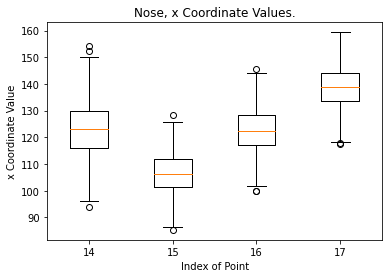

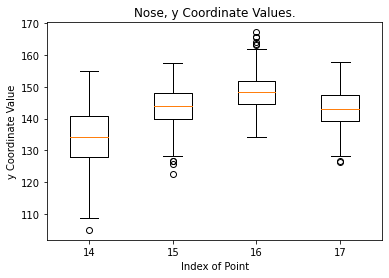

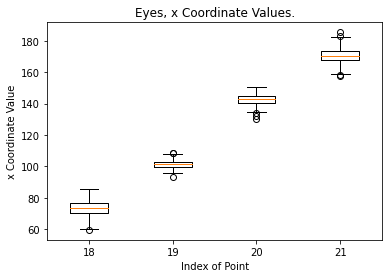

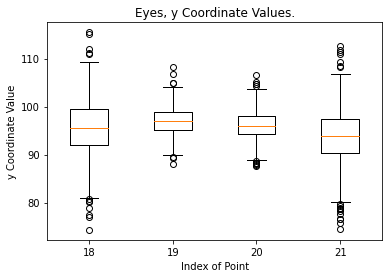

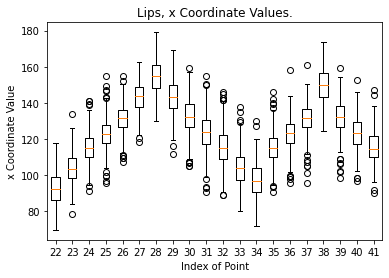

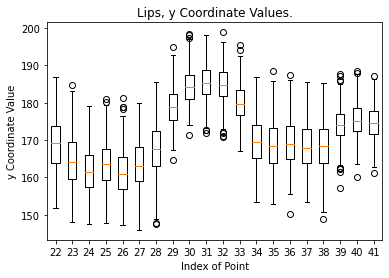

In [ ]:
x_plots = []
y_plots = []
x_axis_labels = []
important_pts_end = {6 : "Face's Outer Structure", 13 : "Eyebrows & Nose Bridge", 17 : "Nose", 21 : "Eyes", 41 : "Lips"}
for pt_idx in range(len(pred_pts[0])):
    x_plots.append([pred_pts[i][pt_idx][0] for i in range(len(pred_pts))])
    y_plots.append([pred_pts[i][pt_idx][1] for i in range(len(pred_pts))])
    x_axis_labels.append(pt_idx)
    if pt_idx in important_pts_end.keys():
        plt.title(important_pts_end.get(pt_idx) + ', x Coordinate Values.')
        plt.boxplot(x_plots, labels=x_axis_labels)
        plt.xlabel('Index of Point')
        plt.ylabel('x Coordinate Value')
        plt.show()
        plt.title(important_pts_end.get(pt_idx) + ', y Coordinate Values.')
        plt.boxplot(y_plots, labels=x_axis_labels)
        plt.xlabel('Index of Point')
        plt.ylabel('y Coordinate Value')
        plt.show()
        x_plots.clear()
        y_plots.clear()
        x_axis_labels.clear()

In [ ]:
all_img_examples = {}
all_img_examples['Good Images'] = [30, 55, 56]
all_img_examples['Face Part Misinterpretation Images'] = [73]
all_img_examples['Outside Points Images'] = [19]
all_img_examples['Images w/Beards'] = [64]
all_img_examples['Images w/Sideway Oriented Faces'] = [81]
all_img_examples['Images w/Bad Lighting'] = [69, 169]

Good Images
Validation Image Number 30.


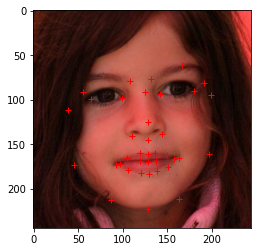

Predicted Points for Image:


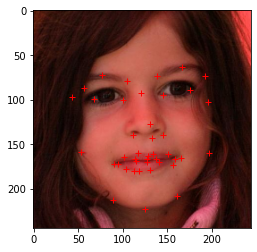

Validation Image Number 55.


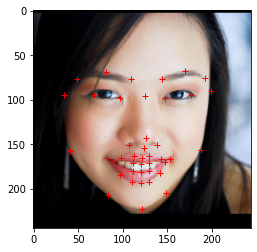

Predicted Points for Image:


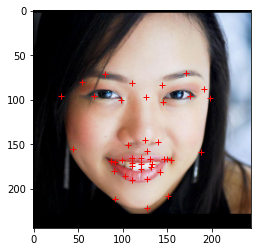

Validation Image Number 56.


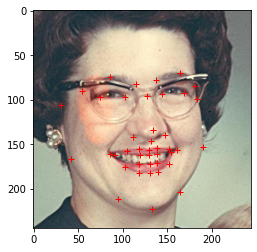

Predicted Points for Image:


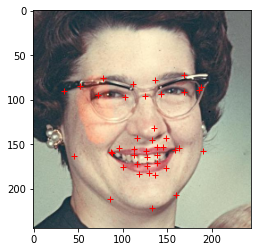













Face Part Misinterpretation Images
Validation Image Number 73.


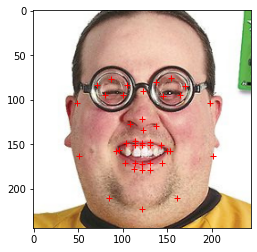

Predicted Points for Image:


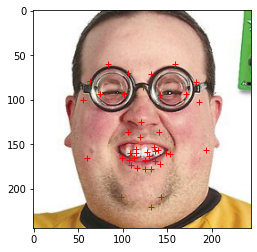













Outside Points Images
Validation Image Number 19.


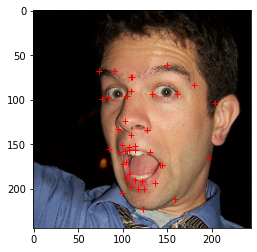

Predicted Points for Image:


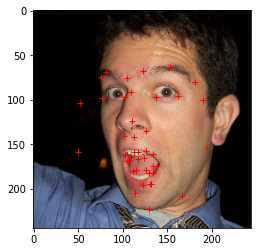













Images w/Beards
Validation Image Number 64.


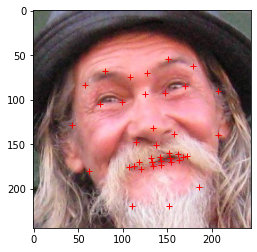

Predicted Points for Image:


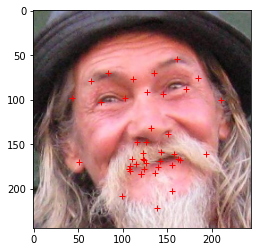













Images w/Sideway Oriented Faces
Validation Image Number 81.


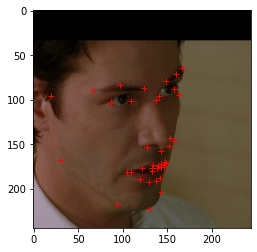

Predicted Points for Image:


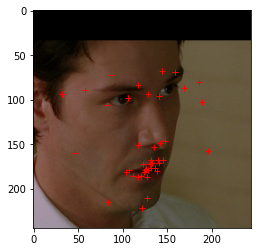













Images w/Bad Lighting
Validation Image Number 69.


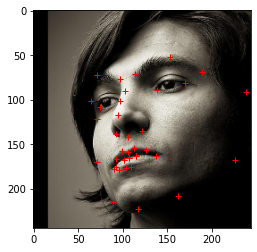

Predicted Points for Image:


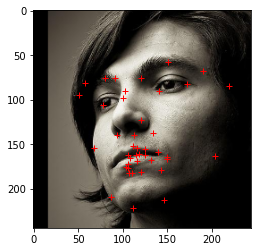

Validation Image Number 169.


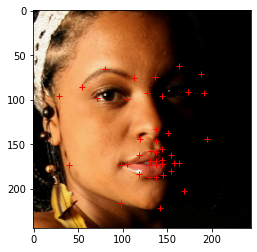

Predicted Points for Image:


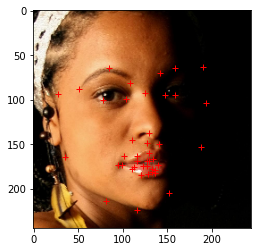

In [ ]:
for imgs_name, img_examples in all_img_examples.items():
    if imgs_name != 'Good Images':
        print('\n\n\n\n\n\n\n\n\n\n\n\n\033[1m' + imgs_name + '\033[1m')
    else:
        print('\033[1m' + imgs_name + '\033[1m')
    for idx in img_examples:
        print(f'Validation Image Number {idx}.')
        visualise_pts(valid_images[idx], valid_pts[idx])
        print('Predicted Points for Image:')
        visualise_pts(valid_images[idx], pred_pts[idx])

In [ ]:
print(np.mean(([0 if n > 5 else 1 for n in dists])))
print(np.mean(([0 if n > 10 else 1 for n in dists])))
print(np.mean(([0 if n > 15 else 1 for n in dists])))
print(np.mean(([0 if n > 20 else 1 for n in dists])))

0.39347254053136405
0.7206094559035735
0.8675833969951617
0.935319582378406


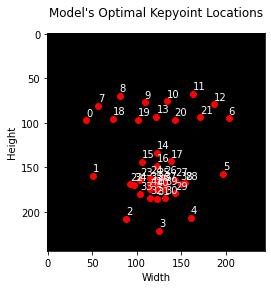

In [ ]:
# visulaizing the optimal point locations used as the keypoint locations for SIFT
plt.imshow(np.zeros((244,244,3), dtype=float))
for i in range(len(model.pts)):
    plt.scatter(model.pts[i][0], model.pts[i][1], c='r')
    plt.annotate(i, (model.pts[i][0], model.pts[i][1] - 5), color='white')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title("Model's Optimal Kepyoint Locations", y=1.05)
plt.show()

In [ ]:
def plot_pt_locations(valid_pts, pred_pts, pt_idx):
    true_pt = [valid_pts[i][pt_idx] for i in range(len(valid_pts))]
    pred_pt = [pred_pts[i][pt_idx] for i in range(len(pred_pts))]
    plt.scatter(*zip(*true_pt), c='r', label='Ground Truth Point Locations')
    plt.scatter(*zip(*pred_pt), c='b', alpha=0.5, label='Predicted Point Locations')
    plt.title(f'Point #{pt_idx + 1} Locations')
    plt.legend(facecolor='white', fontsize=11, loc='upper left')
    plt.show()

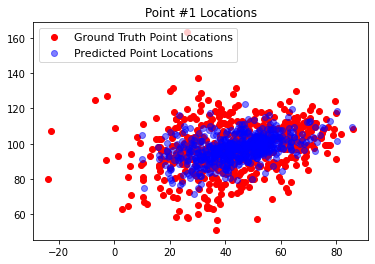

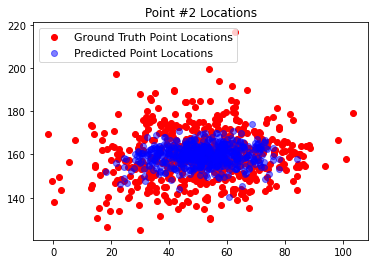

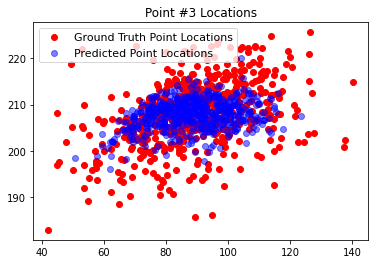

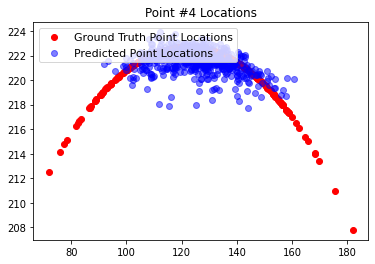

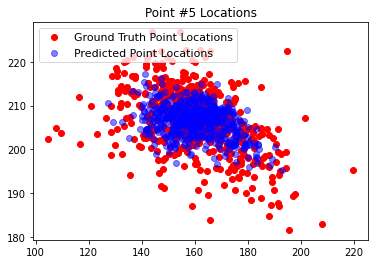

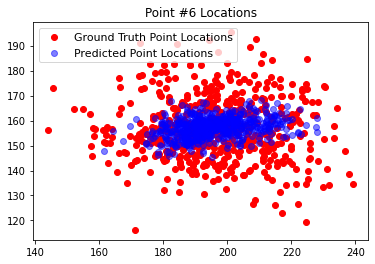

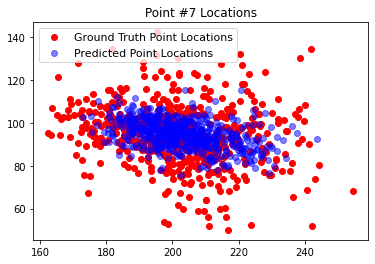

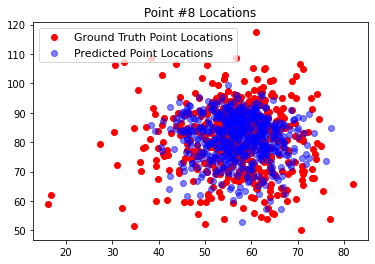

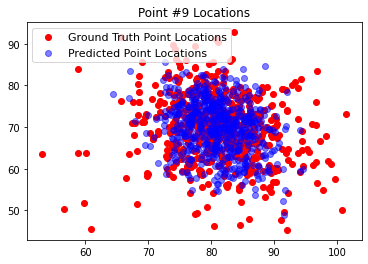

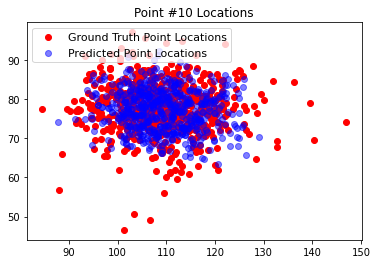

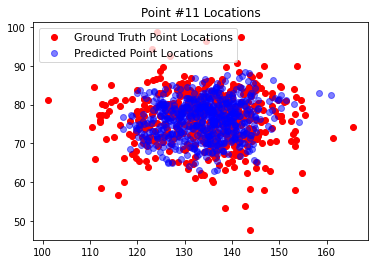

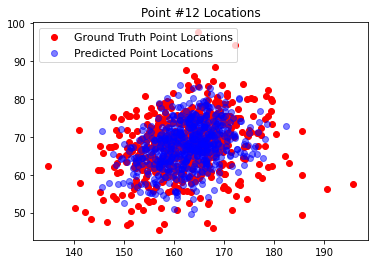

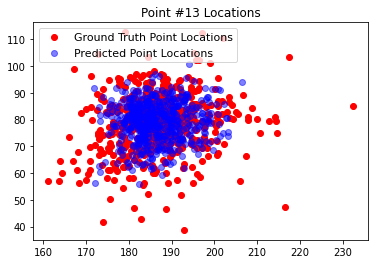

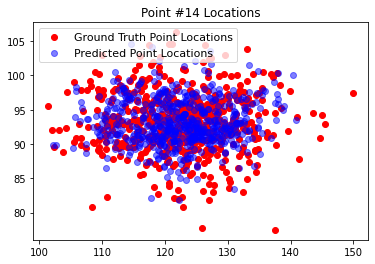

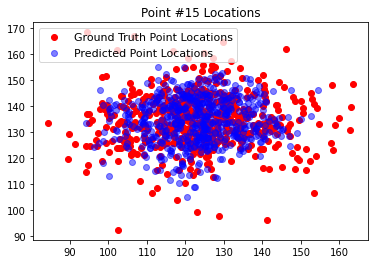

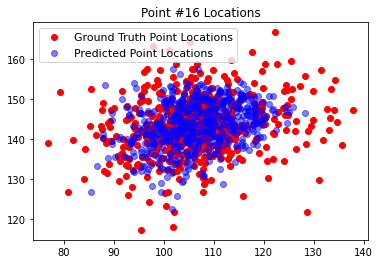

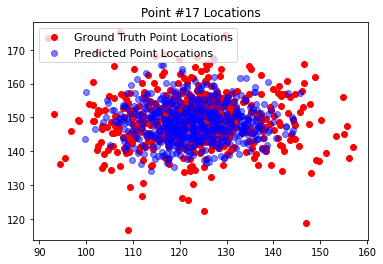

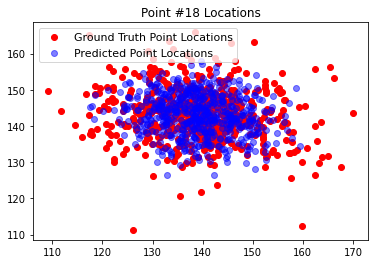

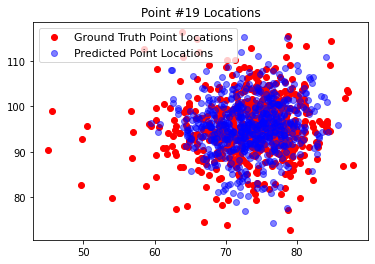

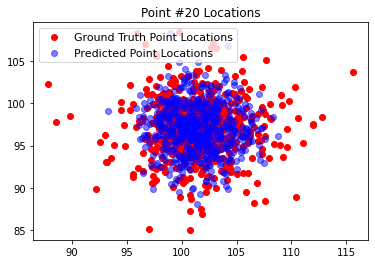

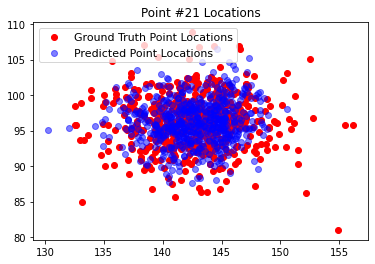

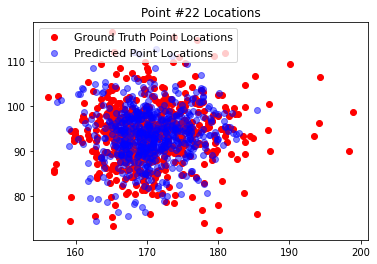

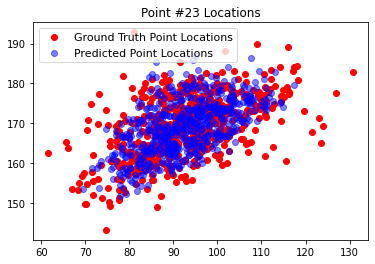

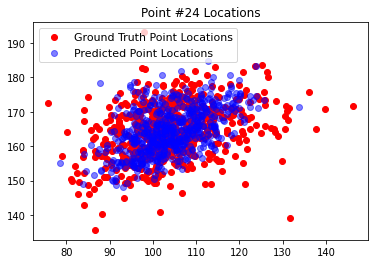

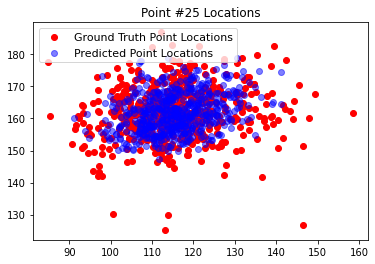

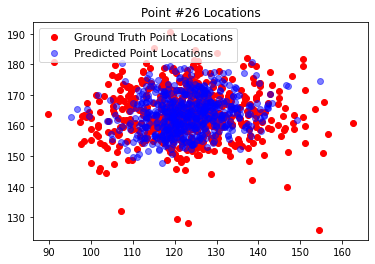

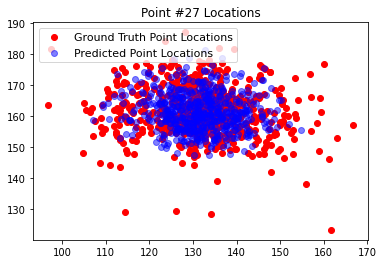

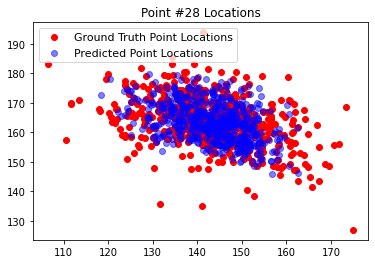

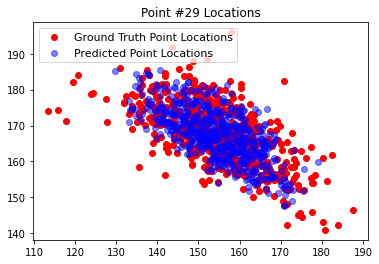

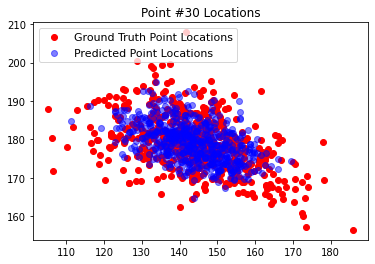

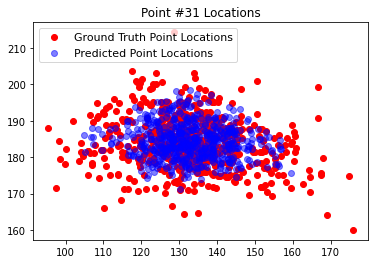

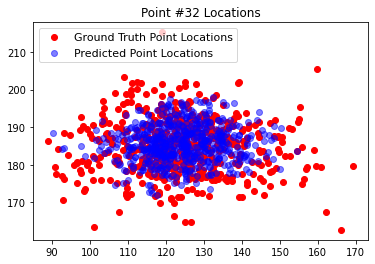

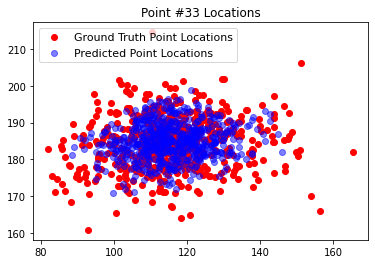

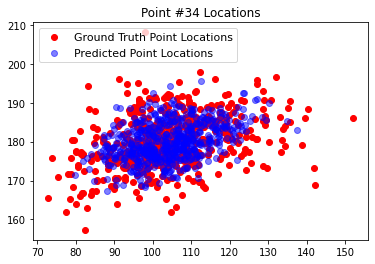

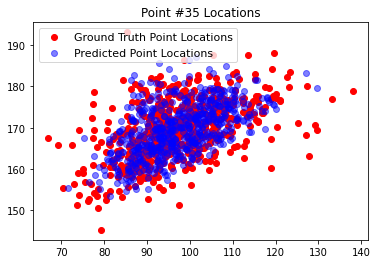

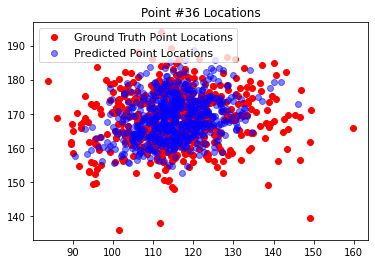

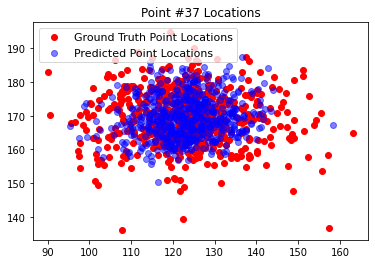

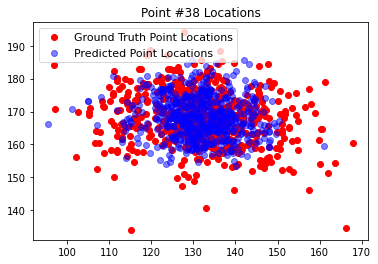

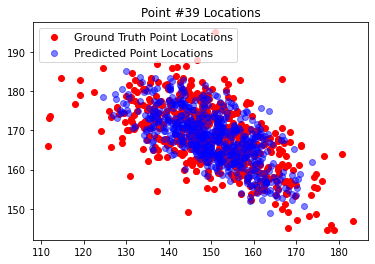

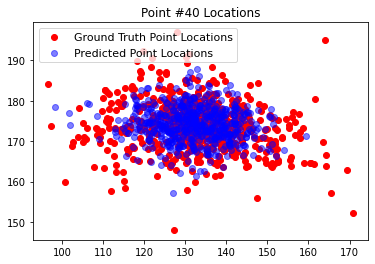

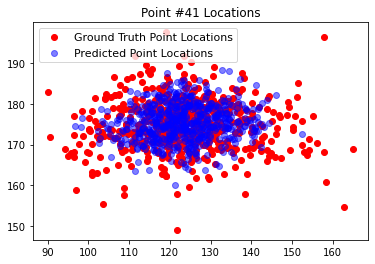

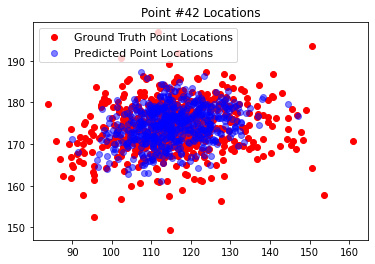

In [ ]:
for i in range(len(valid_pts[0])):
    plot_pt_locations(valid_pts, pred_pts, i)

In [ ]:
test_pred_pts = model.predict(test_images)
save_as_csv(test_pred_pts, '/content/drive/MyDrive/CV Notebooks/CV Report')

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

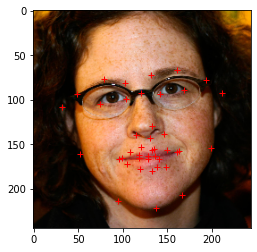

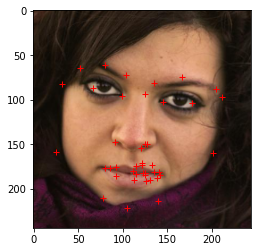

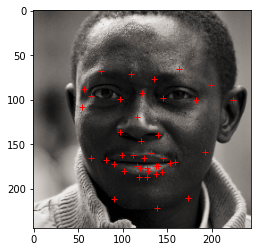

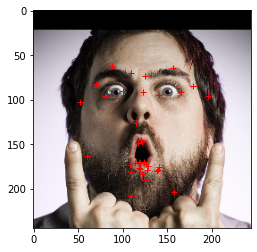

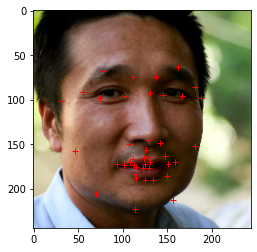

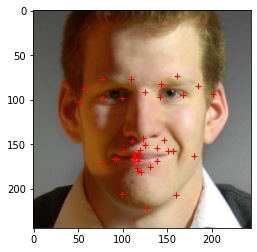

In [ ]:
example_pred_pts = model.predict(example_images)
for idx in range(len(example_pred_pts)):
    visualise_pts(example_images[idx], example_pred_pts[idx])

# Lip Color Modification

In [ ]:
def modify_lip_color(img, pts, color):
    # creating an empty (black) mask of the same shape as the original image
    mask = np.zeros_like(img)
    # getting the points representing the lip's location
    lip_pts = pts[22:]
    # filling the lip's location in the mask with white
    cv2.fillPoly(mask, np.int32([lip_pts]), (255, 255, 255))
    # extracting just the lip from the original image and storing the result in the mask
    mask = cv2.bitwise_and(img,mask)
    # applying a morphological close operation to fill small holes for a more realistic result, a (5, 5) 
    # kernel size is used so that large holes (representing an opened mouth for example) remain unfilled
    kernel = np.ones((5, 5),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # blurring the lips, also adds to the realism of the final result
    mask = cv2.GaussianBlur(mask, (15, 15), cv2.BORDER_DEFAULT)
    # creating an empty image with the same shape as the mask
    lip_img = np.zeros_like(mask)
    # assigning all pixels in the new image with the given color
    lip_img[:] = color
    # making all parts of the new image black, except for the lip which now has the new color applied to it
    lip_img = cv2.bitwise_and(mask, lip_img)
    # comibing the colored lip image and the original image to get the final new image
    final_image = cv2.addWeighted(img,1,lip_img,0.5,0)
    return final_image

22


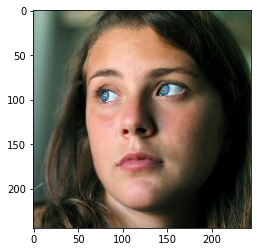

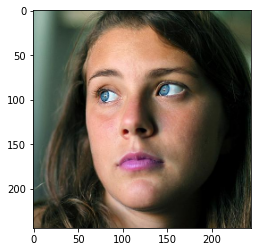

107


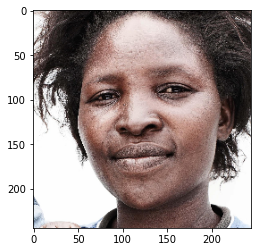

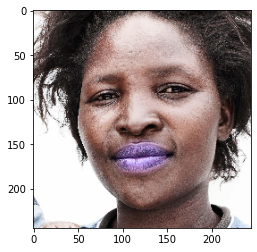

62


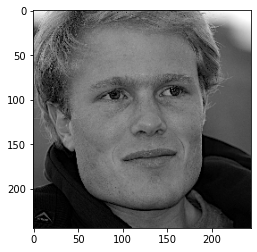

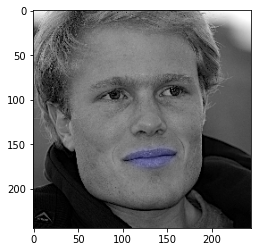

35


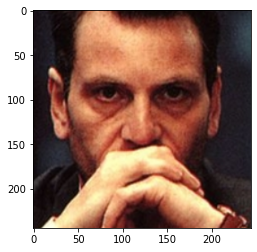

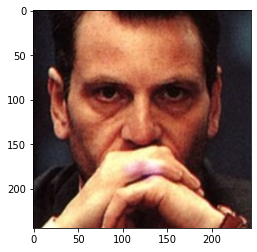

81


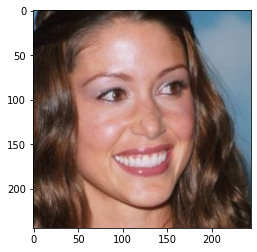

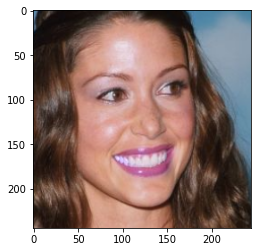

In [ ]:
idxs = [22, 107, 62, 35, 81]
for idx in idxs:
    print(idx)
    plt.imshow(images[idx])
    plt.show()
    plt.imshow(modify_lip_color(images[idx], pts[idx], (0, 0, 255)))
    plt.show()

22


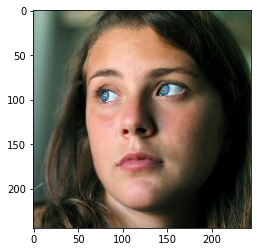

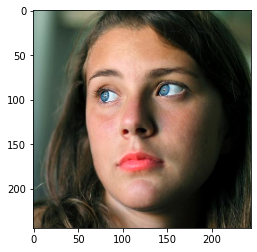

107


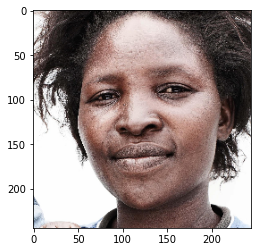

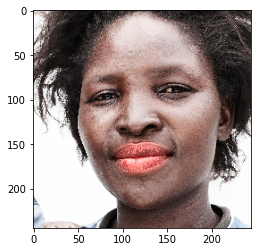

62


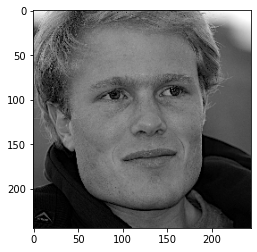

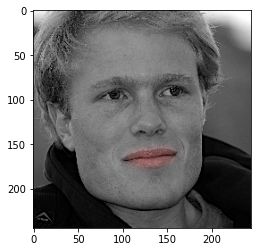

35


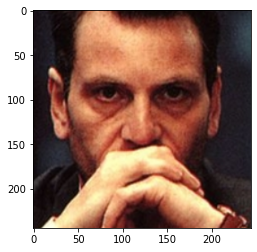

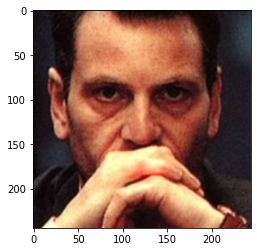

81


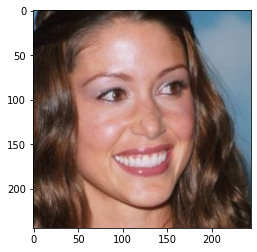

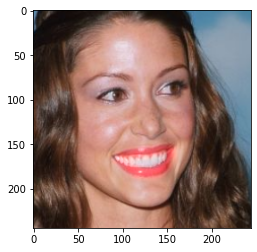

In [ ]:
idxs = [22, 107, 62, 35, 81]
for idx in idxs:
    print(idx)
    plt.imshow(images[idx])
    plt.show()
    plt.imshow(modify_lip_color(images[idx], pts[idx], (255, 0, 0)))
    plt.show()